# Setup

In [1]:
import os
# Move two levels up
os.chdir('..')
# Verify the current directory
print(os.getcwd())

/Users/zekiyan/Library/CloudStorage/GoogleDrive-zettayan@gmail.com/My Drive/Entrepreneur/Sundai/Projects/satellite_image_recognition/Satellite_Image_Object_Recognition


In [2]:
!mkdir predictions
!mkdir activations

mkdir: predictions: File exists
mkdir: activations: File exists


# Packages & Utils

In [3]:
# import packages
import keract

import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from tensorflow.keras.models import load_model

In [4]:
# import utils
from utils.utils import conv_block, decoder_block, build_inception_resnetv2_unet, rgb_to_onehot, onehot_to_rgb, dice_coef

# Color Map

In [5]:
class_dict_df = pd.read_csv('input/class_dict.csv', index_col=False, skipinitialspace=True)
class_dict_df

,name,r,g,b
0,building,60,16,152
1,land,132,41,246
2,road,110,193,228
3,vegetation,254,221,58
4,water,226,169,41
5,unlabeled,155,155,155


In [6]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(60, 16, 152),
  (132, 41, 246),
  (110, 193, 228),
  (254, 221, 58),
  (226, 169, 41),
  (155, 155, 155)],
 ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'])

In [7]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

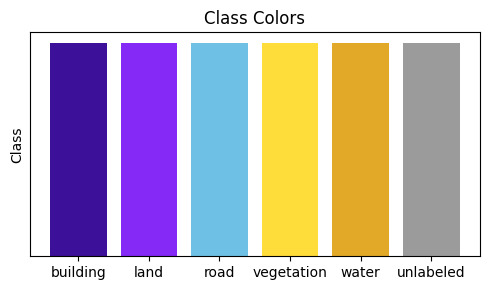

In [8]:
# Create a list of RGB tuples from the DataFrame
colors = [(r/255, g/255, b/255) for r, g, b in zip(class_dict_df['r'], class_dict_df['g'], class_dict_df['b'])]

# Plotting each class with its corresponding RGB color
fig, ax = plt.subplots(figsize=(5, 3))

# Plot each class as a separate bar with its RGB color
ax.bar(class_dict_df['name'], [1]*len(class_dict_df), color=colors)

# Adding labels and title
ax.set_ylabel('Class')
ax.set_title('Class Colors')
ax.set_yticks([])  # Remove y-axis ticks as they are not needed

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

# Modeling

In [9]:
K.clear_session()

In [10]:
model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 255, 255, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 255, 255, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 255, 255, 32)         0         ['batch_n

In [11]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [12]:
model.load_weights("model/InceptionResNetV2-UNet.h5")

In [13]:
image = load_img('input/SerenityCommunity1920By1280_v0_20241228.jpg', target_size= (512, 512))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
y_hat = model.predict(image)

1/1 [==============================] - 2s 2s/step


In [14]:
# activations= keract.get_activations(model, image, nodes_to_evaluate= None, output_format= 'simple', auto_compile= True)
# keract.display_activations(activations, cmap='viridis', save= True, directory= './activations')

1/1 [==============================] - 1s 562ms/step


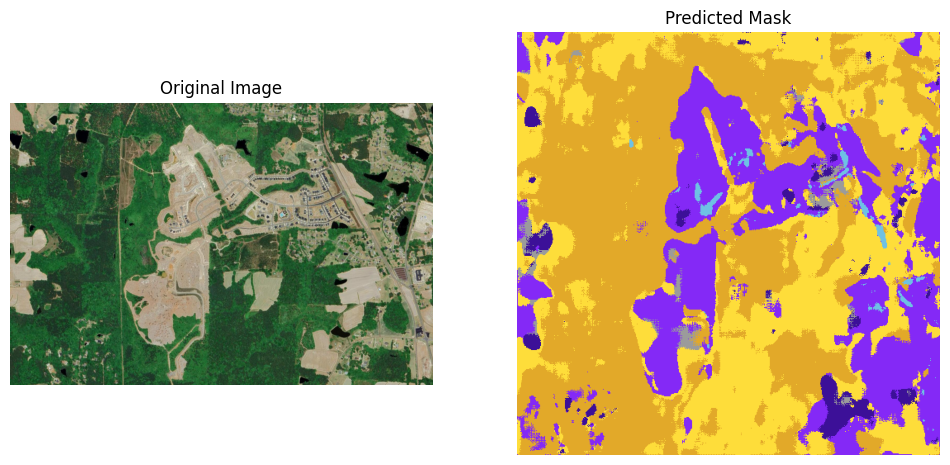

In [15]:
# Define the path to the image
image_path = "input/SerenityCommunity1920By1280_v0_20241228.jpg"

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (512, 512))  # Resize to match model input size
image_array = np.expand_dims(image_resized, axis=0) / 255.0  # Normalize and add batch dimension

# Make prediction
predicted_mask = model.predict(image_array)

# Convert the predicted mask to RGB
predicted_mask_rgb = onehot_to_rgb(predicted_mask[0], id2code)

# Display the original image and the predicted mask
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask_rgb)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()